In [29]:
import numpy as np
import pandas as pd
import mrcfile
import matplotlib.pyplot as plt

from torch_find_peaks import find_peaks_3d
from fle_3d import FLEBasis3D

In [30]:
# Choosing one large protein (per recommendation)
TEMPLATE_PATH = "5MRC_10.00A_solvent-4.530V_real.mrc"

with mrcfile.open(TEMPLATE_PATH, permissive=True) as m:
    template = m.data.astype(np.float32)

print("Template shape:", template.shape)

Template shape: (37, 37, 37)


In [31]:
# building fle 3d and RI volume

fle = FLEBasis3D(
    N=template.shape[0],
    bandlimit=32,
    eps=1e-4
)

def rotation_invariant_volume(fle, volume):
    coeffs = fle.evaluate_t(volume)
    coeffs_tmp = np.zeros_like(coeffs)
    for k in fle.idlm_list[0][0]:   # l=0, m=0 only
        coeffs_tmp[k] = coeffs[k]
    return fle.evaluate(coeffs_tmp).real

template_ri = rotation_invariant_volume(fle, template)

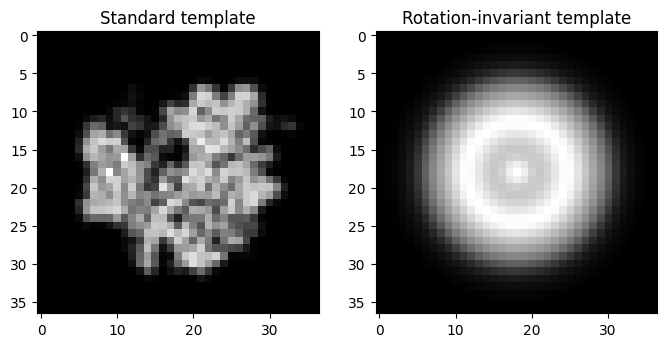

In [32]:
mid = template.shape[0] // 2

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(template[mid], cmap="gray")
axs[0].set_title("Standard template")

axs[1].imshow(template_ri[mid], cmap="gray")
axs[1].set_title("Rotation-invariant template")

plt.show()

In [33]:
with mrcfile.open("grandmodel.mrc", permissive=True) as m:
    grand_model = m.data.astype(np.float32)

with mrcfile.open("reconstruction.mrc", permissive=True) as m:
    reconstruction = m.data.astype(np.float32)

print("Grand model shape:", grand_model.shape)
print("Reconstruction shape:", reconstruction.shape)

/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


Grand model shape: (180, 512, 512)
Reconstruction shape: (512, 512, 512)


In [34]:
def compute_cc2(volume, ref):
    # zero-pad template to volume size
    pad = np.zeros_like(volume)
    sz = ref.shape[0]
    pad[:sz, :sz, :sz] = ref

    F_vol = np.fft.fftn(volume)
    F_ref = np.fft.fftn(pad)

    cc = np.real(np.fft.ifftn(F_vol * np.conj(F_ref)))
    return cc

In [35]:
import torch    
def compute_cc(vol, ref):
    ref_original_shape = ref.shape
    if ref.shape != vol.shape:
        # Apply zero-padding to the smaller volume
        max_shape = np.maximum(ref.shape, vol.shape)
        ref_padded = np.zeros(max_shape, dtype=ref.dtype)
        vol_padded = np.zeros(max_shape, dtype=vol.dtype)
        ref_padded[:ref.shape[0], :ref.shape[1], :ref.shape[2]] = ref
        vol_padded[:vol.shape[0], :vol.shape[1], :vol.shape[2]] = vol
        ref, vol = ref_padded, vol_padded
    assert ref.shape == vol.shape, "Volumes must have the same shape after padding."
    print("Computing CC for volumes of shape:", ref.shape)
    if torch.cuda.is_available():
        vol = torch.tensor(vol, device='cuda')
        ref = torch.tensor(ref, device='cuda')
        F1 = torch.fft.fftn(ref)
        F2 = torch.fft.fftn(vol)
        cc = torch.fft.ifftn(F2 * torch.conj(F1))
        cc= torch.real(cc).cpu().numpy()    
    else:
        F1 = np.fft.fftn(ref)
        F2 = np.fft.fftn(vol)
        cc = np.fft.ifftn(F2 * np.conj(F1))
        cc= np.real(cc)
    cc = np.roll(cc, shift=(ref_original_shape[0]//2, ref_original_shape[1]//2, ref_original_shape[2]//2), axis=(0,1,2))
    return cc , ref

In [36]:
#cc_std = compute_cc(grand_model, template)
#cc_ri  = compute_cc(grand_model, template_ri)





cc_std, ref_padded = compute_cc(grand_model, template)

cc_ri, ref_padded_ri = compute_cc(grand_model, template_ri)
cc_std = np.maximum(cc_std, 0)
cc_ri  = np.maximum(cc_ri, 0)
print("CC volumes computed")

Computing CC for volumes of shape: (180, 512, 512)
Computing CC for volumes of shape: (180, 512, 512)
CC volumes computed


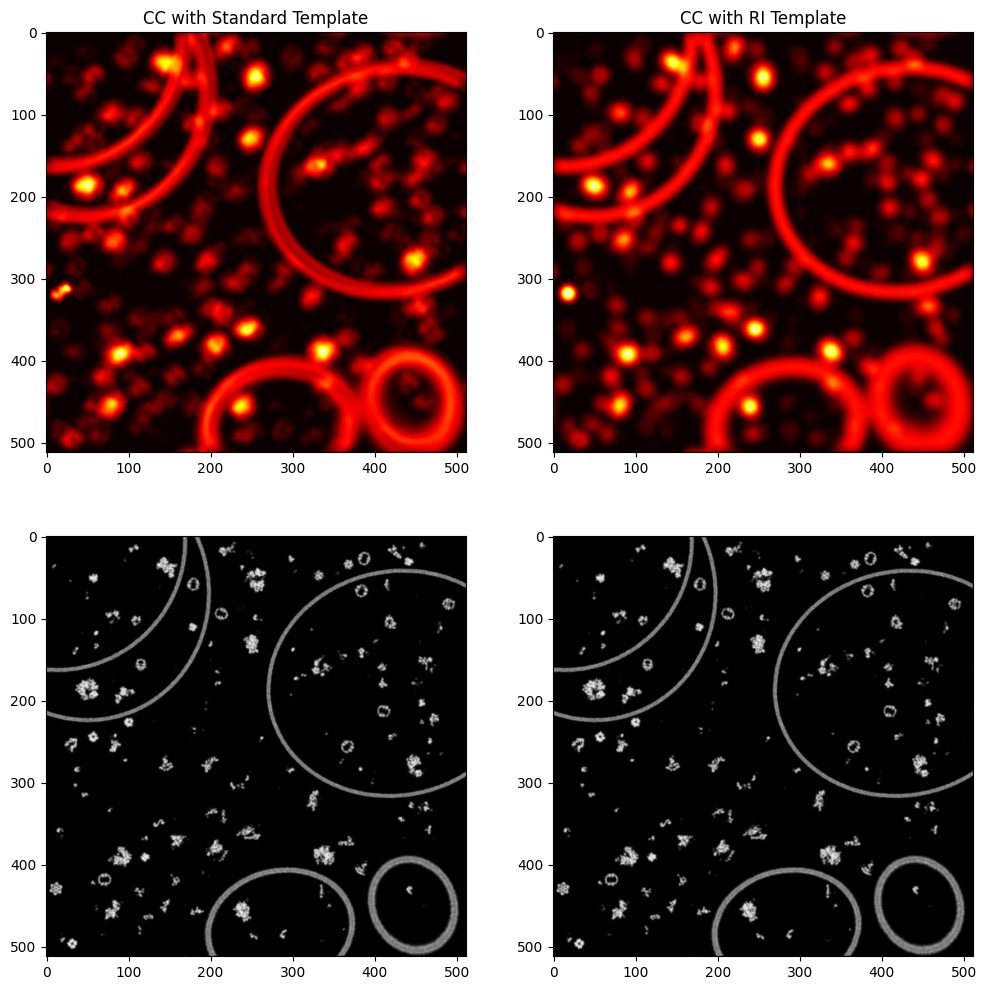

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12,12))
mid = cc_std.shape[0] // 2
ax[0, 0].imshow(cc_std[mid], cmap="hot")
ax[0, 0].set_title("CC with Standard Template")
ax[0, 1].imshow(cc_ri[mid], cmap="hot")
ax[0, 1].set_title("CC with RI Template")
ax[1,0].imshow(grand_model[mid], cmap="gray")
ax[1,1].imshow(grand_model[mid], cmap="gray")

In [38]:
print("Tomogram shape:", reconstruction.shape)
print("Template shape:", template.shape, template_ri.shape)

Tomogram shape: (512, 512, 512)
Template shape: (37, 37, 37) (37, 37, 37)


In [39]:
from torch_find_peaks import find_peaks_3d

# Detect peaks
peaks_std = find_peaks_3d(
    cc_std,
    min_distance=1,
    threshold_abs=0.01,
    return_as="torch"
)

peaks_ri = find_peaks_3d(
    cc_ri,
    min_distance=1,
    threshold_abs=0.01,
    return_as="torch"
)

print("STD peaks:", peaks_std[0].shape)
print("RI  peaks:", peaks_ri[0].shape)

STD peaks: torch.Size([6651, 3])
RI  peaks: torch.Size([3556, 3])


tensor([[  0,   0, 390],
        [  0,  13, 459],
        [  0,  16, 502],
        ...,
        [179, 497, 310],
        [179, 511,  66],
        [179, 511, 151]])
80


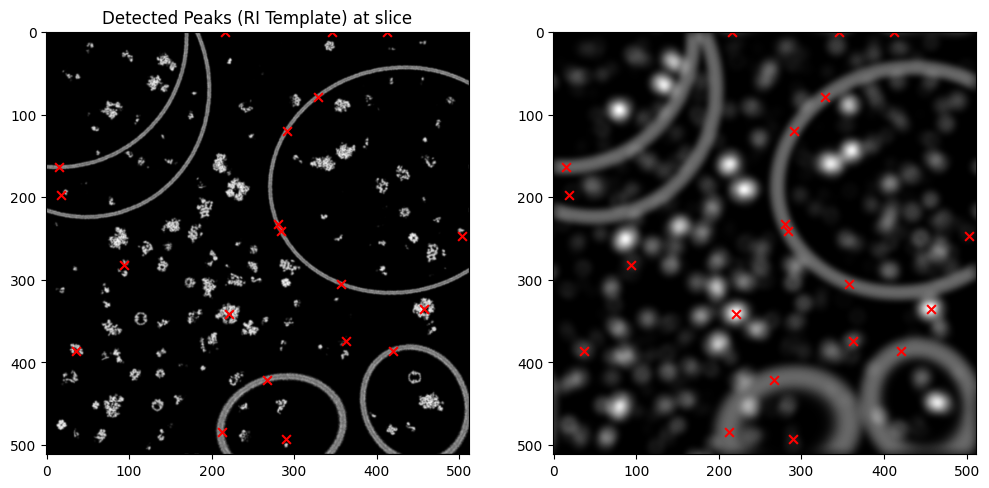

In [40]:
print(peaks_ri[0])

slice_id = 80
print(slice_id)


#x_coord, y_coord = y_coord, x_coord  # swapped in pea
# ks
# take all peaks that are at mid slice
subset_mask = peaks_ri[0][:,0] == slice_id
subset_peaks_ri = peaks_ri[0][subset_mask]

# Mark the peaks on the image
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(grand_model[slice_id], cmap="gray")
ax[0].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')
ax[0].set_title("Detected Peaks (RI Template) at slice")
ax[1].imshow(cc_ri[slice_id], cmap="gray")
ax[1].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')

In [41]:
TOPK = 150 # checking with different values
top_std = peaks_std[0][peaks_std[1].argsort(descending=True)[:TOPK]] # is size of template,shape[0] //2

print(cc_ri.shape)
top_ri  = peaks_ri[0][peaks_ri[1].argsort(descending=True)[:TOPK]]# is size of template,shape[0] //2

print("Top peaks (ri):", top_ri)

#print("scores (ri):", peaks_ri[1][peaks_ri[1].argsort(descending=True)[:TOPK]])

(180, 512, 512)
Top peaks (ri): tensor([[ 53, 424, 317],
        [ 53, 423, 320],
        [ 56, 427, 319],
        [ 55, 426, 321],
        [ 44, 382, 290],
        [ 44, 379, 291],
        [ 43, 382, 295],
        [ 59, 252, 109],
        [ 55, 249, 103],
        [124, 323, 378],
        [127, 331, 374],
        [ 94, 316,  19],
        [101, 321,  16],
        [163, 358, 234],
        [163, 360, 235],
        [116, 456, 324],
        [133, 339, 236],
        [ 98, 370, 162],
        [130, 120,  60],
        [ 97, 195,  93],
        [106,  84, 360],
        [ 73, 238, 152],
        [ 73, 378, 198],
        [123, 480, 285],
        [106,  79, 474],
        [126, 429,  69],
        [135, 444, 151],
        [ 36, 384, 332],
        [141, 352, 384],
        [ 47, 268,  58],
        [ 68, 230, 404],
        [ 63,  47,  66],
        [ 92,  54, 256],
        [131, 181, 412],
        [110, 341, 487],
        [145,  19, 425],
        [ 28, 480, 148],
        [ 94, 280, 450],
        [128, 319,

In [42]:
import pandas as pd

gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
)
print(gt["label"].unique())
# Keeping only protein particles (include vesicle + fiducial)
gt_protein = gt[~gt["label"].isin(["vesicle", "fiducial"])]

################### Limited to only 5MRC proteins
gt_protein = gt_protein[gt_protein["label"] == "5MRC"] 
############################


gt_xyz = gt_protein[["x", "y", "z"]].values

print("GT protein particles:", gt_xyz.shape)


['vesicle' 'fiducial' '1BXN' '1U6G' '3QM1' '1S3X' '4V94_fixed' '4CR2'
 '2CG9' '3H84' '3D2F' '1QVR' '5MRC' '3GL1' '3CF3']
GT protein particles: (131, 3)


In [43]:
import numpy as np
from scipy.spatial import cKDTree

def evaluate_detections(detected_xyz, gt_xyz, max_dist=8):
    """
    detected_xyz: (N,3) array of detected peak coordinates (z,y,x)
    gt_xyz:       (M,3) array of GT particle coordinates
    max_dist:     max distance (voxels) to count as correct detection
    """
    tree = cKDTree(gt_xyz)
    matched_gt = set()
    distances = []

    for p in detected_xyz:
        dist, idx = tree.query(p, k=1)
        if dist <= max_dist and idx not in matched_gt:
            matched_gt.add(idx)
            distances.append(dist)

    return np.array(distances), matched_gt

In [44]:
#evaluating how many of those top-K are close to real particles

dist_std, hits_std = evaluate_detections(
    top_std.cpu().numpy(),
    gt_xyz,
    max_dist=2
)

dist_ri, hits_ri = evaluate_detections(
    top_ri.cpu().numpy(),
    gt_xyz,
    max_dist=2
)

print("STD hits:", len(hits_std), "/", TOPK)
print("RI  hits:", len(hits_ri),  "/", TOPK)

print(hits_ri)

STD hits: 78 / 150
RI  hits: 131 / 150
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130}


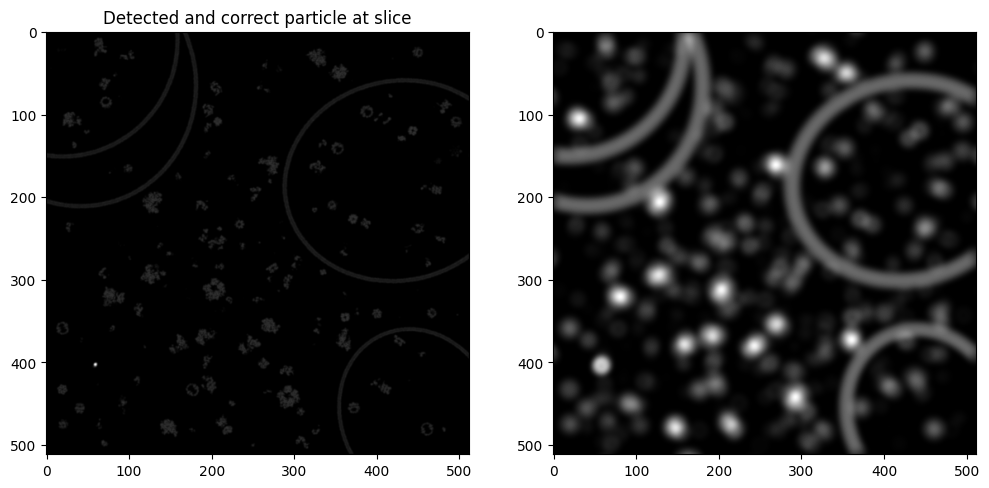

In [45]:


slice_id = 23


# take all peaks that are at mid slice
subset_mask = gt_xyz[list(hits_ri)][:,0] == slice_id
subset_peaks_ri = gt_xyz[list(hits_ri)][subset_mask]



# Mark the peaks on the image
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(grand_model[slice_id], cmap="gray")
ax[0].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')
ax[0].set_title("Detected and correct particle at slice")
ax[1].imshow(cc_ri[slice_id], cmap="gray")
ax[1].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')

In [46]:
import pandas as pd

gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
)
print(gt["label"].unique())
# Keeping only protein particles (include vesicle + fiducial)
gt_protein = gt[~gt["label"].isin(["vesicle", "fiducial"])]

################### Limited to only 5MRC proteins
gt_protein = gt_protein[gt_protein["label"] == "5MRC"] 
############################


gt_xyz = gt_protein[["x", "y", "z"]].values

print("GT protein particles:", gt_xyz.shape)


['vesicle' 'fiducial' '1BXN' '1U6G' '3QM1' '1S3X' '4V94_fixed' '4CR2'
 '2CG9' '3H84' '3D2F' '1QVR' '5MRC' '3GL1' '3CF3']
GT protein particles: (131, 3)


In [47]:

from scipy.spatial import cKDTree

def evaluate_detections(detected_xyz, gt_xyz, max_dist=8):
    tree = cKDTree(gt_xyz)
    matched_gt = set()
    distances = []

    for p in detected_xyz:
        dist, idx = tree.query(p, k=1)
        if dist <= max_dist and idx not in matched_gt:
            matched_gt.add(idx)
            distances.append(dist)

    return np.array(distances), matched_gt

In [48]:
def extract_patch(volume, center, size=32):
    z, y, x = map(int, center)
    h = size // 2
    return volume[z-h:z+h, y-h:y+h, x-h:x+h]

tensor([153, 293, 215])


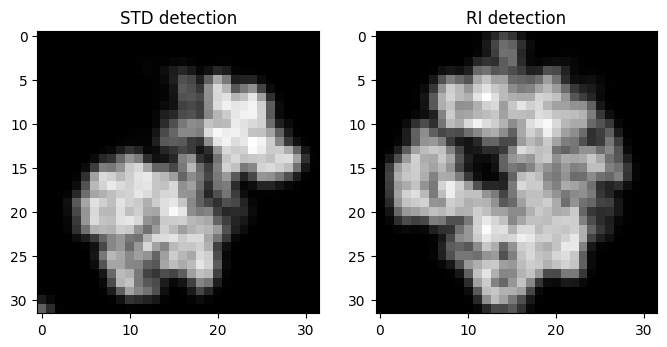

In [49]:
# Picking one mid-ranked detection (not rank 1, often fiducial)
idx = 78 

z_std, y_std, x_std = top_std[idx].cpu().numpy().astype(int)
z_ri,  y_ri,  x_ri  = top_ri[idx].cpu().numpy().astype(int)
print(top_ri[idx])
patch_std = extract_patch(grand_model, (z_std, y_std, x_std))
patch_ri  = extract_patch(grand_model, (z_ri,  y_ri,  x_ri))

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(patch_std[patch_std.shape[0]//2], cmap="gray")
axs[0].set_title("STD detection")
axs[1].imshow(patch_ri[patch_ri.shape[0]//2], cmap="gray")
axs[1].set_title("RI detection")
plt.show()

In [50]:
# Loading reconstruction for comparison

rec = mrcfile.open("reconstruction.mrc", permissive=True).data.copy()

# reconstruction ≈ grand_model shifted by ~166 voxels in z
Z_OFFSET = 166

/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


In [51]:
# import mrcfile
# import numpy as np

# # Read original reconstruction
# with mrcfile.open("reconstruction.mrc", permissive=True) as m:
#     recon = m.data.astype(np.float32)

# # Invert intensities
# recon_inv = -recon


# # Save inverted volume to new MRC
# with mrcfile.new("reconstruction_inverted.mrc", overwrite=True) as m:
#     m.set_data(recon_inv.astype(np.float32))

# # Update in-memory variable if you want to use it in the notebook
# rec = recon_inv

# print("Saved reconstruction_inverted.mrc, shape:", rec.shape,"min/max:", rec.min(), rec.max())
# Z_OFFSET = 166




In [52]:
cc_std_rec, _ = compute_cc(rec, template)
cc_ri_rec,  _ = compute_cc(rec, template_ri)

#cc_ri_rec = torch.abs(torch.tensor(cc_ri_rec)).numpy()

cc_std_rec = np.maximum(-cc_std_rec, 0)
cc_ri_rec  = np.maximum(-cc_ri_rec,0)

print("Reconstruction CC computed")

Computing CC for volumes of shape: (512, 512, 512)


Computing CC for volumes of shape: (512, 512, 512)
Reconstruction CC computed


In [53]:
import mrcfile
import numpy as np

# Save STD score volume
with mrcfile.new(
    "recon_5MRC_std/reconstruction_fixed_scores.mrc",
    overwrite=True
) as m:
    m.set_data(cc_std_rec.astype(np.float32))

# Save RI score volume
with mrcfile.new(
    "recon_5MRC_ri/reconstruction_fixed_scores.mrc",
    overwrite=True
) as m:
    m.set_data(cc_ri_rec.astype(np.float32))

print("STD and RI score volumes saved")

STD and RI score volumes saved


In [54]:
print(cc_std_rec.shape)

(512, 512, 512)


In [55]:
from torch_find_peaks import find_peaks_3d

peaks_std_rec = find_peaks_3d(cc_std_rec, min_distance=1, threshold_abs=0.02, return_as="torch")
peaks_ri_rec  = find_peaks_3d(cc_ri_rec,  min_distance=1, threshold_abs=0.02, return_as="torch")

In [56]:
#evaluating how many of those top-K are close to real particles
TOPK = 1000

top_std_rec = peaks_std_rec[0][peaks_std_rec[1].argsort(descending=True)[:TOPK]] #+ template.shape[0]//2
top_ri_rec  = peaks_ri_rec[0][peaks_ri_rec[1].argsort(descending=True)[:TOPK]]  #+ template.shape[0]//2

gt_xyz_rec = gt_xyz.copy()
gt_xyz_rec[:,0] += Z_OFFSET




dist_std_rec, hits_std_rec = evaluate_detections(
    top_std_rec.cpu().numpy(),
    gt_xyz_rec,
    max_dist=8
)

dist_ri_rec, hits_ri_rec = evaluate_detections(
    top_ri_rec.cpu().numpy(),
    gt_xyz_rec,
    max_dist=8
)

print("STD hits:", len(hits_std_rec), "/", TOPK)
print("RI  hits:", len(hits_ri_rec),  "/", TOPK)


STD hits: 44 / 1000
RI  hits: 128 / 1000


tensor([214, 378, 290])


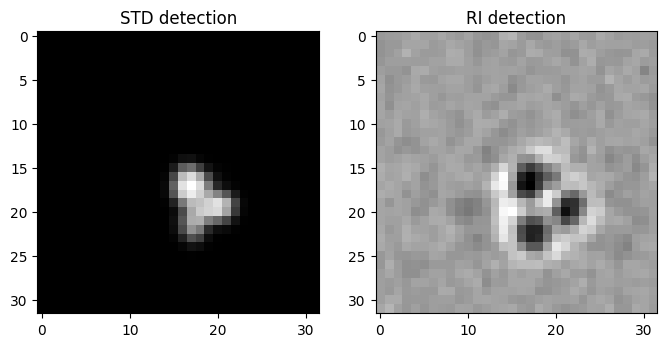

In [57]:
# Picking one mid-ranked detection (not rank 1, often fiducial)
idx = 21

z_std, y_std, x_std = top_std[idx].cpu().numpy().astype(int)
z_ri,  y_ri,  x_ri  = top_ri_rec[idx].cpu().numpy().astype(int)
print(top_ri_rec[idx])

patch_ri  = extract_patch(reconstruction, (z_ri,  y_ri,  x_ri))
patch_ri_grand  = extract_patch(grand_model, (z_ri-166,  y_ri,  x_ri))

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(patch_ri_grand[patch_ri_grand.shape[0]//2], cmap="gray")
axs[0].set_title("STD detection")
axs[1].imshow(patch_ri[patch_ri.shape[0]//2], cmap="gray")
axs[1].set_title("RI detection")
plt.show()

[[322 453 419]]


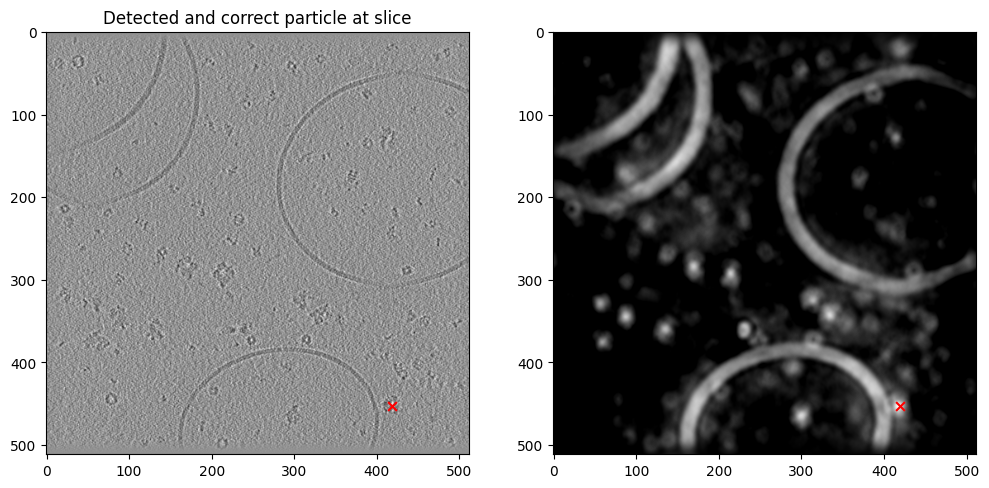

In [58]:


slice_id = 322



#x_coord, y_coord = y_coord, x_coord  # swapped in pea
# ks


# take all peaks that are at mid slice

subset_mask = gt_xyz_rec[list(hits_ri)][:,0] == slice_id
subset_peaks_ri = gt_xyz_rec[list(hits_ri)][subset_mask]

print(subset_peaks_ri)
#subset_peaks_ri = np.array([[76, 22, 114]]) 

# Mark the peaks on the image
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(reconstruction[slice_id], cmap="gray")
ax[0].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')
ax[0].set_title("Detected and correct particle at slice")
ax[1].imshow(cc_ri_rec[slice_id], cmap="gray")
ax[1].scatter(subset_peaks_ri[:,2], subset_peaks_ri[:,1], c='r', s=40, marker='x')

#Further analysis

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

from scipy.spatial import cKDTree
import numpy as np

def match_detections(pred_xyz, gt_xyz, threshold):
    tree = cKDTree(gt_xyz)
    dists, idx = tree.query(pred_xyz)

    hits_mask = dists < threshold
    unique_gt_hits = np.unique(idx[hits_mask])

    tp = len(unique_gt_hits)
    fp = len(pred_xyz) - tp
    fn = len(gt_xyz) - tp

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return tp, fp, fn, precision, recall, f1, dists

In [60]:
def precision_recall_curve_manual(pred_xyz, gt_xyz, scores, dist_thresh=5):
    thresholds = np.linspace(scores.min(), scores.max(), 50)

    precisions = []
    recalls = []

    for t in thresholds:
        mask = scores >= t
        tp, fp, fn, precision, recall, _, _ = match_detections(
            pred_xyz[mask], gt_xyz, dist_thresh
        )

        precisions.append(precision)
        recalls.append(recall)

    return thresholds, np.array(precisions), np.array(recalls)

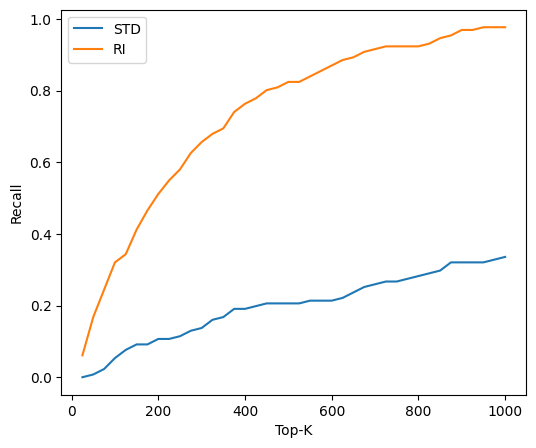

In [61]:
from scipy.spatial import cKDTree
import numpy as np

def recall_vs_k(peaks_rec, gt_xyz_rec, max_k=1000, step=25, threshold=8):

    tree = cKDTree(gt_xyz_rec)

    Ks = []
    recalls = []

    # sort once
    sorted_idx = peaks_rec[1].argsort(descending=True)

    for K in range(step, max_k+1, step):

        top_coords = peaks_rec[0][sorted_idx[:K]].cpu().numpy()

        dists, idx = tree.query(top_coords)

        matched = idx[dists < threshold]

        unique_hits = np.unique(matched)

        recall = len(unique_hits) / len(gt_xyz_rec)

        Ks.append(K)
        recalls.append(recall)

    return Ks, recalls


Ks_std, rec_std = recall_vs_k(peaks_std_rec, gt_xyz_rec)
Ks_ri, rec_ri   = recall_vs_k(peaks_ri_rec,  gt_xyz_rec)

plt.figure(figsize=(6,5))
plt.plot(Ks_std, rec_std, label="STD")
plt.plot(Ks_ri,  rec_ri,  label="RI")
plt.xlabel("Top-K")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [62]:
# ---- Extract coords and scores ----

coords_std = peaks_std_rec[0].cpu().numpy()   # (N,3)
scores_std = peaks_std_rec[1].cpu().numpy()

coords_ri = peaks_ri_rec[0].cpu().numpy()
scores_ri = peaks_ri_rec[1].cpu().numpy()

# Sort by score descending
order_std = np.argsort(-scores_std)
order_ri  = np.argsort(-scores_ri)

coords_std = coords_std[order_std]
scores_std = scores_std[order_std]

coords_ri  = coords_ri[order_ri]
scores_ri  = scores_ri[order_ri]

print("STD detections:", len(coords_std))
print("RI detections:", len(coords_ri))

STD detections: 745895
RI detections: 39880


In [63]:
from scipy.spatial import cKDTree

def evaluate_ranked(coords, gt_xyz, max_dist=8):
    tree = cKDTree(gt_xyz)

    matched_gt = set()
    precision = []
    recall = []
    tps = 0

    for k in range(1, len(coords)+1):
        dist, idx = tree.query(coords[k-1])

        if dist < max_dist and idx not in matched_gt:
            tps += 1
            matched_gt.add(idx)

        precision.append(tps / k)
        recall.append(tps / len(gt_xyz))

    return np.array(precision), np.array(recall)


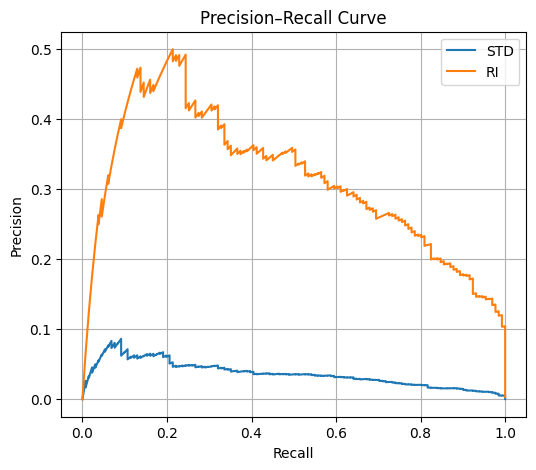

In [64]:
prec_std, rec_std = evaluate_ranked(coords_std, gt_xyz_rec, max_dist=8)
prec_ri,  rec_ri  = evaluate_ranked(coords_ri,  gt_xyz_rec, max_dist=8)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.plot(rec_std, prec_std, label="STD")
plt.plot(rec_ri,  prec_ri,  label="RI")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid()
plt.show()

In [65]:
aupr_std = np.trapz(prec_std, rec_std)
aupr_ri  = np.trapz(prec_ri,  rec_ri)

print("AUPR STD:", aupr_std)
print("AUPR RI :", aupr_ri)

AUPR STD: 0.036091222347028024
AUPR RI : 0.30892519048472716


In [66]:
def compute_roc(coords, gt_xyz, max_dist=8):
    tree = cKDTree(gt_xyz)

    matched_gt = set()
    tps = 0
    fps = 0

    tpr = []
    fpr = []

    total_pos = len(gt_xyz)
    total_neg = len(coords) - total_pos

    for k in range(len(coords)):
        dist, idx = tree.query(coords[k])

        if dist < max_dist and idx not in matched_gt:
            tps += 1
            matched_gt.add(idx)
        else:
            fps += 1

        tpr.append(tps / total_pos)
        fpr.append(fps / total_neg)

    return np.array(fpr), np.array(tpr)

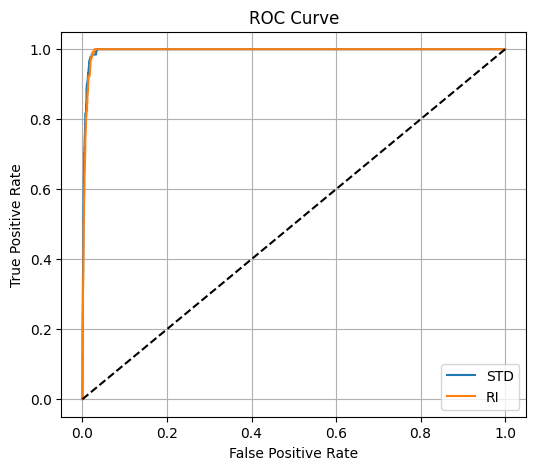

In [67]:
fpr_std, tpr_std = compute_roc(coords_std, gt_xyz_rec)
fpr_ri,  tpr_ri  = compute_roc(coords_ri,  gt_xyz_rec)
plt.figure(figsize=(6,5))
plt.plot(fpr_std, tpr_std, label="STD")
plt.plot(fpr_ri,  tpr_ri,  label="RI")

plt.plot([0,1],[0,1],'k--')  # random line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def nearest_distances(pred_xyz, gt_xyz):
    tree = cKDTree(gt_xyz)
    dists, _ = tree.query(pred_xyz, k=1)
    return dists


# Consistent color scheme for whole notebook
COLOR_RI  = "#E69F00"   # orange
#COLOR_STD = "#0072B2"   # blue
COLOR_STD = "#009E73" # green (if needed)
# 3D distances
d_ri  = nearest_distances(ri_xyz,  gt_xyz)
d_std = nearest_distances(std_xyz, gt_xyz)

print("RI median distance:", np.median(d_ri))
print("STD median distance:", np.median(d_std))
print("RI mean distance:", np.mean(d_ri))
print("STD mean distance:", np.mean(d_std))

plt.figure(figsize=(7,5))
plt.hist(d_ri, bins=50, alpha=0.6,color="red", label="RI")
plt.hist(d_std, bins=50, alpha=0.6, color=COLOR_STD, label="STD")
plt.axvline(5, color='k', linestyle='--', label="5 voxel threshold")

plt.xlabel("Nearest GT Distance (voxels)")
plt.ylabel("Count")
plt.title("Distance Distribution of Detections")
plt.legend()
plt.show()


def cumulative_curve(dists):
    sorted_d = np.sort(dists)
    recall_like = np.arange(1, len(sorted_d)+1) / len(sorted_d)
    return sorted_d, recall_like

d_ri_sorted,  r_ri  = cumulative_curve(d_ri)
d_std_sorted, r_std = cumulative_curve(d_std)

plt.figure(figsize=(6,5))
plt.plot(d_ri_sorted,  r_ri, color="red", label="RI")
plt.plot(d_std_sorted, r_std, color=COLOR_STD, label="STD")

plt.xlabel("Distance threshold (voxels)")
plt.ylabel("Fraction of detections within threshold")
plt.title("Cumulative Distance Curve")
plt.legend()
plt.show()



NameError: name 'ri_xyz' is not defined

In [69]:
plt.figure(figsize=(6,5))

plt.scatter(std_scores, d_std, alpha=0.3, color="blue", label="STD")
plt.scatter(ri_scores, d_ri, alpha=0.3, color= "red", label="RI")
plt.xlabel("Correlation score")
plt.ylabel("Nearest GT distance (voxels)")
plt.title("Score vs Distance")
plt.legend()
plt.show()

NameError: name 'std_scores' is not defined

<Figure size 600x500 with 0 Axes>